# Selecting data

The primary data filtering method of ModelSkill is the `sel()` method
which is accesible on most ModelSkill data structures. The `sel()`
method is a wrapper around
[`xarray.Dataset.sel`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html#xarray.Dataset.sel)
and can be used to select data based on time, location and/or variable.
The `sel()` method returns a new data structure of the same type with
the selected data.

## TimeSeries data

Point and track timeseries data of both observation and model result
kinds are stored in
[`TimeSeries`](../api/TimeSeries.html#modelskill.TimeSeries) objects
which uses
[`xarray.Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html#xarray.Dataset)
as data container. The
[`sel()`](../api/TimeSeries.html#modelskill.TimeSeries.sel) method can
be used to select data based on time and returns a new
[`TimeSeries`](../api/TimeSeries.html#modelskill.TimeSeries) object with
the selected data.

In [1]:
import modelskill as ms
o = ms.observation("../data/obs.nc", item="waterlevel", gtype='point')
o_1month = o.sel(time=slice("2018-01-01", "2018-02-01"))
o_1month

<PointObservation>: obs
Location: nan, nan
Time: 2018-01-01 00:00:00 - 2018-02-01 23:00:00
Quantity:  []

------------------------------------------------------------------------

## Comparer objects

The [`Comparer`](../api/Comparer.html#modelskill.Comparer) and
[`ComparerCollection`](../api/ComparerCollection.html#modelskill.ComparerCollection)
objects hold matched data from observations and model results, enabling
you to evaluate model performance effectively. These objects provide
intuitive methods to filter and query data based on time, model,
quantity, or spatial criteria.

The primary methods for filtering the data are:

-   **`sel()`**: Use for structured selections based on time, model, or
    spatial boundaries.
-   **`where()`**: Use for conditional filtering based on logical
    criteria.
-   **`query()`**: Use for flexible, expression-based filtering in a
    pandas-like style.

In [2]:
o = ms.observation("../data/SW/HKNA_Hm0.dfs0", item=0,
                    x=4.2420, y=52.6887,
                    name="HKNA")
m1 = ms.model_result("../data/SW/HKZN_local_2017_DutchCoast.dfsu", 
                      item="Sign. Wave Height",
                      name="m1")
m2 = ms.model_result("../data/SW/CMEMS_DutchCoast_2017-10-28.nc", 
                      item="VHM0",
                      name="m2")

In [3]:
cmp = ms.match(o, [m1, m2])

### `sel()` method

The [`sel`](../api/Comparer.html#modelskill.Comparer.sel) method allows
you to select data based on specific criteria such as time, model name,
or spatial area. It returns a new `Comparer` object with the selected
data. This method is highly versatile and supports multiple selection
parameters, which can be combined.

**Syntax:** `Comparer.sel(model=None, time=None, area=None)`

| Parameter | Type | Description | Default |
|----------|-------------------|-------------------------------------|-------|
| `model` | str, int, or list | Model name or index. Selects specific models. | None |
| `time` | str, datetime, or slice | Specific time or range for selection. | None |
| `area` | list of float or Polygon | Bounding box \[x0, y0, x1, y1\] or a polygon area filter. | None |

**Example 1: Selecting data by time**

In [4]:
cmp_12hrs = cmp.sel(time=slice('2017-10-28', '2017-10-28 12:00'))
cmp_12hrs

<Comparer>
Quantity: Significant wave height [m]
Observation: HKNA, n_points=66
Model(s):
0: m1
1: m2

This selects data within the specified time range.

**Example 2: Selecting a specific model**

In [5]:
cmp_m1 = cmp.sel(model='m1')
cmp_m1

<Comparer>
Quantity: Significant wave height [m]
Observation: HKNA, n_points=120
Model(s):
0: m1

This filters the data to include only the model named “m1”.

**Example 3: Selecting a spatial area**

In [6]:
cmp_area = cmp.sel(area=[4.0, 52.5, 5.0, 53.0])

This filters the data within the bounding box defined by
`[x0, y0, x1, y1]`.

### `where()` method

The [`where`](../api/Comparer.html#modelskill.Comparer.where) method is
used to filter data conditionally. It works similarly to `xarray`’s
`where` method and returns a new `Comparer` object with values
satisfying a given condition. Other values will be masked (set to
`NaN`).

**Syntax:** `Comparer.where(cond)`

| Parameter | Type | Description |
|----------|-------------------------|--------------------------------------|
| `cond` | bool, np.ndarray, or xr.DataArray | Condition to filter values (True or False). |

**Example 4: Filtering data conditionally**

In [7]:
cmp.where(cmp.data.Observation > 3)

<Comparer>
Quantity: Significant wave height [m]
Observation: HKNA, n_points=52
Model(s):
0: m1
1: m2

This filters out any rows where the observation values are not greater
than 3.

**Example 5: Multiple conditions**

In [8]:
cmp.where((cmp.data.m1 < 2.9) & (cmp.data.Observation > 3))

<Comparer>
Quantity: Significant wave height [m]
Observation: HKNA, n_points=8
Model(s):
0: m1
1: m2

This filters the data to include rows where `m1 < 2.9` and
`Observation > 3.0`.

### `query()` method

The [`query`](../api/Comparer.html#modelskill.Comparer.query) method
uses a
[`pandas.DataFrame.query`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html#pandas.DataFrame.query)-style
syntax to filter data based on string-based expressions. It provides a
flexible way to apply complex filters using column names and logical
operators.

**Syntax:** `Comparer.query(query)`

| Parameter | Type | Description                      |
|-----------|------|----------------------------------|
| `query`   | str  | Query string for filtering data. |

**Example 6: Querying data**

In [9]:
cmp.query("Observation > 3.0 and m1 < 2.9")

<Comparer>
Quantity: Significant wave height [m]
Observation: HKNA, n_points=8
Model(s):
0: m1
1: m2

This filters the data where `Observation` is greater than 3.0 and `m1`
is less than 2.9.

------------------------------------------------------------------------

## Skill objects

The [`skill()`](../api/Comparer.html#modelskill.Comparer.skill) and
[`mean_skill()`](../api/ComparerCollection.html#modelskill.ComparerCollection.mean_skill)
methods return a
[`SkillTable`](../api/SkillTable.html#modelskill.SkillTable) object with
skill scores from comparing observation and model result data using
different metrics (e.g. root mean square error). It returns a
[`SkillTable`](../api/SkillTable.html#modelskill.SkillTable) object,
which wraps a
[`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame)
and organizes the skill scores for further filtering, visualization, or
analysis.

The resulting
[`SkillTable`](../api/SkillTable.html#modelskill.SkillTable) object
provides several methods to facilitate filtering and formatting: -
**`sel()`**: Select specific models or observations. - **`query()`**:
Apply flexible conditions with pandas-like queries.

In [10]:
sk = cmp.skill(metrics=["rmse", "mae", "si"])
sk

**Example 7: Select model**

In [11]:
sk.sel(model='m1')

Here, `sk` contains skill scores for all models, and `sk_m1` filters the
results to include only model “m1”. Observations can be selected in the
same way.

**Example 8: Querying skill scores**

In [12]:
sk_high_rmse = sk.query("rmse > 0.3")
sk_high_rmse

This filters the `SkillTable` to include only rows where the root mean
square error (RMSE) exceeds 0.3.

**Example 9: Accessing and visualizing specific metrics**

In [13]:
sk_rmse = sk.rmse
sk_rmse

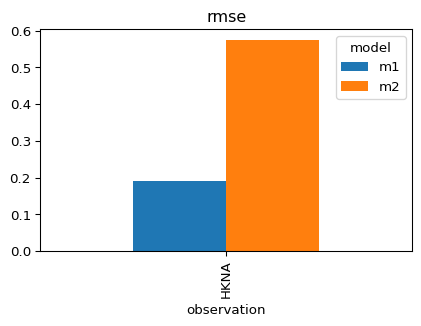

In [14]:
sk_rmse.plot.bar(figsize=(5,3))

The `rmse` attribute directly accesses the RMSE column from the
`SkillTable`, which can then be plotted or analyzed further.